In [ ]:
!pip install gdown
!pip install tqdm
!pip install tensorflow
!pip install nltk
!pip install evaluate
!pip install rouge_score

In [2]:
import os
import pickle
import gdown
import zipfile
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 19 20:36:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
def download_and_extract(url, output_zip, extract_to):
    """
    Downloads and extracts a zip file from the given URL.
    """
    if not os.path.exists(output_zip):
        print("Downloading dataset...")
        gdown.download(url, output_zip, quiet=False)
    else:
        print(f"{output_zip} already exists. Skipping download.")

    if not os.path.exists(extract_to):
        print("Extracting dataset...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(output_zip, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Dataset extracted to: {extract_to}")
    else:
        print(f"{extract_to} already exists. Skipping extraction.")

# Flickr8k dataset Google Drive URL
url = "https://drive.google.com/uc?id=1iFgG55ZUR1ZO-BrIc5PQ1AhrWa0NhQVZ"
output_zip = "flickr8k.zip"
extract_to = "./flickr8k"

# Download and extract the dataset
download_and_extract(url, output_zip, extract_to)


Downloading...
From (original): https://drive.google.com/uc?id=1iFgG55ZUR1ZO-BrIc5PQ1AhrWa0NhQVZ
From (redirected): https://drive.google.com/uc?id=1iFgG55ZUR1ZO-BrIc5PQ1AhrWa0NhQVZ&confirm=t&uuid=0b5b0ac7-604b-47ef-9f73-856d06116a5c
To: /content/flickr8k.zip
100%|██████████| 1.12G/1.12G [00:09<00:00, 114MB/s]


Extracting dataset...
Dataset extracted to: ./flickr8k


In [5]:
model = VGG16()
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
features = {}
BASE_DIR = './flickr8k/flicker8k'
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
image_ids = list(mapping.keys())
max_length = max(len(caption.split()) for caption in all_captions)
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
inputs1 = Input(shape=(4096,))
fe = Dense(256, activation='relu')(Dropout(0.4)(inputs1))
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
se2 = LSTM(256)(Dropout(0.4)(se1))
decoder1 = add([fe, se2])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - loss: 5.7787
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - loss: 4.0558
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 3.5787
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 3.2963
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 3.0991
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 2.9502
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 2.8305
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 2.7344
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 2.6589
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 2.5946
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - loss: 2.5305
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - loss: 2.4744
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 2.4302
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 2.3828
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 2.3467
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 2.3099
227/227 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - loss: 2.27

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [29]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

In [61]:
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))

BLEU-2: 0.312257
BLEU-2: 0.192964


In [46]:
reference_captions = [
    [" ".join(ref).replace('startseq', '').replace('endseq', '').strip() for ref in references]
    for references in actual
]

In [51]:
generated_captions = [
    " ".join(caption).replace('startseq', '').replace('endseq', '').strip()
    for caption in predicted
]


In [62]:
metrics = compute_evaluation_metrics(generated_captions, reference_captions)
print(f"METEOR Score: {metrics['meteor']}")
print(f"ROUGE-1 Score: {metrics['rouge1']}")
print(f"ROUGE-2 Score: {metrics['rouge2']}")
print(f"ROUGE-L Score: {metrics['rougeL']}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.2812746425861505
ROUGE-1 Score: 0.3316899086376107
ROUGE-2 Score: 0.12154767430936952
ROUGE-L Score: 0.31014076919886013


In [68]:
from PIL import Image
import matplotlib.pyplot as plt
def show_generated_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    plt.imshow(image)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Generated Captions--------------------')
    print(" ".join(y_pred.split(" ")[1:-1]))
    print('---------------------Reference Captions---------------------')
    for caption in captions:
        print(" ".join(caption.split(" ")[1:-1]))

--------------------Generated Captions--------------------
two people are walking past pond in lake
---------------------Reference Captions---------------------
couple stands close at the water 's edge
the two people stand by body of water and in front of bushes in fall
two people hold each other near pond
two people stand by the water
two people stand together on the edge of the water on the grass


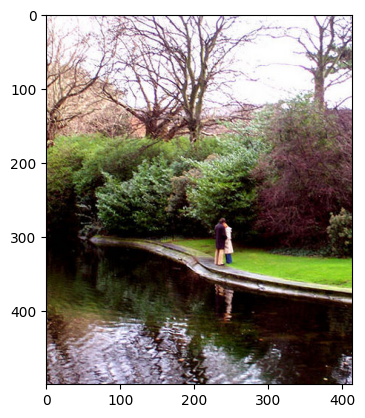

In [69]:
show_generated_caption("3637013_c675de7705.jpg")

--------------------Generated Captions--------------------
man waterskiing in lake
---------------------Reference Captions---------------------
man in swim trunks and red life vest jet skiing
man waterskiing with one hand
man wearing red life jacked is holding purple rope while waterskiing
man wearing swimming trunks is waterskiing backwards using only one hand
person in red ski jacket skiing backwards


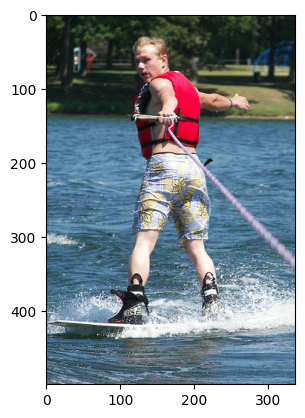

In [75]:
show_generated_caption("172097782_f0844ec317.jpg")